# Introduction
This web site is running a "Jupyter notebook," which allows you to execute interactive Octave
code directly in your browser. Each (part of a code) line preceeded by a percent symbol "%" is a code comment.

To execute any Octave commands, first enter the commands in a code cell, and then depress the "shift" and "enter" keys on your keyboard at the same time, making sure that your cursor is placed inside of the code cell.
I refer to this as "< shift \> < enter \>" in my instructions below.

The output from this notebook will be used to provide answers for this lesson's practice
quiz. As you proceed through the specialization, you will use more and more Jupyter notebooks
to write Octave code to implement battery-management-system algorithms.

In [1]:
% Place your cursor in this input code cell. Then, type < shift >< enter > to execute

% This loads the OCV Test Script data from storage for a 25 degC test
load E2_OCV_P25.mat

In [2]:
% The variable "OCVData" has been loaded by the previous input box. Place 
% your cursor in this input code cell and depress < shift >< enter >

whos





Variables visible from the current scope:

variables in scope: top scope

  Attr   Name         Size                     Bytes  Class
  ====   ====         ====                     =====  ===== 
         OCVData      1x1                    2034720  struct
         ans          1x4                          4  char

Total is 5 elements using 2034724 bytes



**Do not attempt to display the `OCVData` variable!** It contains an enormous amount of data and will probably crash your web browser if you attempt to do so.
`OCVData` has four fields: `script1`, `script2`, `script3`, and `script4`. These contain data corresponding to the four test scripts you have learned about this week.
Each of these fields further has sub-fields holding the data of interest. These are: 

1) Data from OCV Test Script 1 (at test temperature, which is 25 degC here)

`OCVData.script1.time: [9429x1 double]
OCVData.script1.step: [9429x1 double]
OCVData.script1.current: [9429x1 double]
OCVData.script1.voltage: [9429x1 double]
OCVData.script1.chgAh: [9429x1 double]
OCVData.script1.disAh: [9429x1 double]`

2) Data from OCV Test Script 2 (at 25 degC)

`OCVData.script2.time: [11987x1 double]
OCVData.script2.step: [11987x1 double]
OCVData.script2.current: [11987x1 double]
OCVData.script2.voltage: [11987x1 double]
OCVData.script2.chgAh: [11987x1 double]
OCVData.script2.disAh: [11987x1 double]`

3) Data from OCV Test Script 3 (at test temperature, also 25 degC here)

`OCVData.script3.time: [9286x1 double]
OCVData.script3.step: [9286x1 double]
OCVData.script3.current: [9286x1 double]
OCVData.script3.voltage: [9286x1 double]
OCVData.script3.chgAh: [9286x1 double]
OCVData.script3.disAh: [9286x1 double]`

4) Finally, data from OCV Test Script 4 (at 25 degC)

`OCVData.script4.time: [11688x1 double]
OCVData.script4.step: [11688x1 double]
OCVData.script4.current: [11688x1 double]
OCVData.script4.voltage: [11688x1 double]
OCVData.script4.chgAh: [11688x1 double]
OCVData.script4.disAh: [11688x1 double]`

### Visualizing data
There is an enormous amount of data stored from these four cell tests. One good way to visualize the data is via plotting. For example:

In [3]:
% Plot the voltage response from script 1
% Place your cursor in this input code cell. Then, type < shift >< enter > to execute

plot(OCVData.script1.time/3600,OCVData.script1.voltage); % 3600 converts seconds into hours
title('Voltage versus time for OCV Test Script #1')
xlabel('Time (hr)')
ylabel('Voltage (V)')
grid on
% Feel free to modify this code input cell to plot different things!

Inline plot failed, consider trying another graphics toolkit

error: print: rendering with fltk toolkit requires visible figure (DISPLAY=':0')
error: called from
    _make_figures>safe_print at line 125 column 7
    _make_figures at line 49 column 13



### Finding coulombic efficiency
The data provided for use with this notebook are all measured at 25<sup>o</sup>C. We can use these data to find the coulombic efficiency of the cell at this temperature, as discussed in the lesson.

In [5]:
% Place your cursor in this input code cell. Then, type < shift >< enter > to execute
totDisAh = OCVData.script1.disAh(end) + OCVData.script2.disAh(end) + ...
           OCVData.script3.disAh(end) + OCVData.script4.disAh(end);
totChgAh = OCVData.script1.chgAh(end) + OCVData.script2.chgAh(end) + ...
           OCVData.script3.chgAh(end) + OCVData.script4.chgAh(end);
eta25 = totDisAh/totChgAh

eta25 =  0.98340


### Finding total capacity
We can also find the cell's total capacity (result is displayed in ampere hours).

In [6]:
% Place your cursor in this input code cell. Then, type < shift >< enter > to execute
Q25 = OCVData.script1.disAh(end) + OCVData.script2.disAh(end) - ...
      eta25*OCVData.script1.chgAh(end) - eta25*OCVData.script2.chgAh(end)

Q25 =  5.2127


### Finding approximate OCV relationship at this temperature
The following code computes the approximate OCV versus SOC relationship using only the 25<sup>o</sup>C data set. The code is functionally the same as what you learned about in the lesson.

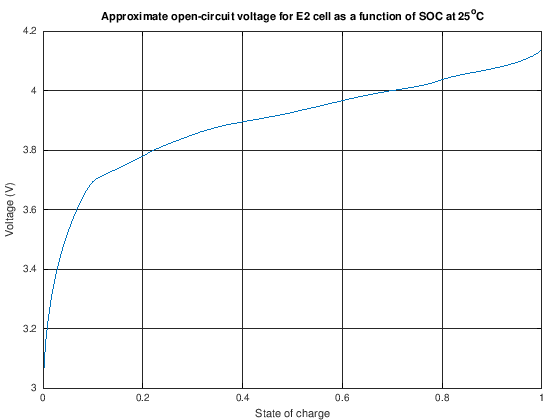

In [7]:
% Place your cursor in this input code cell. Then, type < shift >< enter > to execute
SOC = 0:0.005:1; % output SOC points for this step

indD  = find(OCVData.script1.step == 2); % slow discharge
IR1Da = OCVData.script1.voltage(indD(1)-1) - OCVData.script1.voltage(indD(1));
IR2Da = OCVData.script1.voltage(indD(end)+1) - OCVData.script1.voltage(indD(end));

indC  = find(OCVData.script3.step == 2); % slow charge
IR1Ca = OCVData.script3.voltage(indC(1)) - OCVData.script3.voltage(indC(1)-1);
IR2Ca = OCVData.script3.voltage(indC(end)) - OCVData.script3.voltage(indC(end)+1);
IR1D = min(IR1Da,2*IR2Ca); IR2D = min(IR2Da,2*IR1Ca);
IR1C = min(IR1Ca,2*IR2Da); IR2C = min(IR2Ca,2*IR1Da);

blend = (0:length(indD)-1)/(length(indD)-1);
IRblend = IR1D + (IR2D-IR1D)*blend(:);
disV = OCVData.script1.voltage(indD) + IRblend;
disZ = 1 - OCVData.script1.disAh(indD)/Q25;
disZ = disZ + (1 - disZ(1));

blend = (0:length(indC)-1)/(length(indC)-1);
IRblend = IR1C + (IR2C-IR1C)*blend(:);
chgV = OCVData.script3.voltage(indC) - IRblend;
chgZ = OCVData.script3.chgAh(indC)/Q25;
chgZ = chgZ - chgZ(1);

deltaV50 = interp1(chgZ,chgV,0.5) - interp1(disZ,disV,0.5);
ind = find(chgZ < 0.5);
vChg = chgV(ind) - chgZ(ind)*deltaV50;
zChg = chgZ(ind);
ind = find(disZ > 0.5);
vDis = flipud(disV(ind) + (1 - disZ(ind))*deltaV50);
zDis = flipud(disZ(ind));
rawocv = interp1([zChg; zDis],[vChg; vDis],SOC,'linear','extrap');

% At this point, the pair {SOC,rawocv} form a lookup table for the approximate OCV versus SOC relationship
% We can plot this relationship:
plot(SOC,rawocv)                
xlabel('State of charge')
ylabel('Voltage (V)') 
grid on
title('Approximate open-circuit voltage for E2 cell as a function of SOC at 25^oC')

### Table lookup
The relationship for OCV versus SOC is not yet final since we have processed only one temperature at this point. However, we can still use the computations performed to date in order to find a table-lookup approximate value of OCV as a function of SOC. 

In [10]:
% Place your cursor in this input code cell. Then, type < shift >< enter > to execute

testSOC = 0.25; % Replace "0.30" with whatever value of SOC for which you desire to know OCV
OCV = interp1(SOC,rawocv,testSOC)

OCV =  3.8201


In [9]:
dir


.
..
.hidden
.ipynb_checkpoints
.readonly
Capstone project, Part 1 - old.ipynb
Capstone project, Part 2 - old.ipynb
Capstone project, Part 3 - old.ipynb
Capstone project.ipynb
Notebook for course 2, week 2 quiz.ipynb
Notebook for lesson 2.2.5.ipynb
Notebook for lesson 2.3.3.ipynb
Notebook for lesson 2.3.5.ipynb
Notebook for lesson 2.3.6.ipynb
Notebook for lesson 2.3.7.ipynb
Notebook for lesson 2.4.1.ipynb
Notebook for lesson 2.4.2.ipynb
Notebook for lesson 2.4.4.ipynb
Notebook for lesson 2.4.5.ipynb
Notebook for lessons 2.5.5 and 2.5.6.ipynb
P14model-ocv.mat
P14model.mat
Untitled.ipynb
octave-workspace
readonly


In [3]:
dir readonly

.                     P14_DYN               processOCV.m
..                    P14_OCV               pulseData.mat
.ipynb_checkpoints    P14model-ocv.mat      pulseModel.mat
E1model.mat           SOCfromOCVtemp.m      runProcessDynamic.m
E2_DYN_P25.mat        Untitled.ipynb        runProcessOCV.m
E2_OCV_P25.mat        getParamESC.m         setupDynData.m
E2model.mat           hwy.txt               simCell.m
E2model2RC.mat        nycc.txt              udds.txt
E2model2RCmatlab.mat  octave-workspace      us06.txt
OCVfromSOCtemp.m      processDynamic.m


In [4]:
edit readonly/E2model.mat